# Fantasy Hockey Draft List Generator
** Final Project for DSE200x by Jeff Puuri **

Abstract: In 2017, it was estimated that there were over 50 million participants in online fantasy sports.  Participation in fantasy sports is a leisure activity, but many play for money as well as pride.

Drafting the best team at the start of each season is a major key to a successful season as measured by winning one's league, or finishing 'in the money' (usually the top 3 spots).  In helping participants prepare for a draft, many online leagues provide a suggested draft list, based on 'expert' advice, that ranks sports players' projected performance in the upcoming season that rely mainly on last year's player stats only.  It can be shown, based on average draft position, that league-provided suggested draft lists are the predominant source for draft selections.

Are these league-provided draft lists, the best source for one's draft choices?  Or is it possible to apply data science to create an improved draft list of players, based on more than just last years stats, that can provide a fantasy participant with an advantage at draft time over those using the draft list provided by the online fantasy host?

The goal in drafting a better team is to give one a better chance of their team finishing the season in the top spots, providing enhanced enjoyment, pride, and possible winnings in leagues that play for money.

This project study will produce a model for Fantasy Hockey using Yahoo Sports, the online service in which I have participated with same league for over ten years.  Therefore I will use the same statistical categories that are used by my league.  Although the model produced by this study is specific to the sport of hockey and a certain set of statsitical categories used by my leagues, I would like to demonstrate that this approach could be extended to other fantasy sports and the statistical categories defined for a participant's particular league.

One other note is that this study is geared towards season-long fantasy leagues, and not daily matchups that are becoming popular.

In [1]:
# import libraries to use
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
dataFolder = 'D:/PjtData/4_PD/edX_DSE200x/wk10_FinalPjt/'

## Import Datasets
The next step is to import the datasets that will be used in the analysis.  One set is going to contain the predicted and actual rankings from Yahoo Sports for all players for the 2017-18 season (ranks).  The other contains the player statistics for 2004-2017 from Hockey-Reference.com that has been cleansed by a user through Kaggle (stats).  Finally we have the final stats for the 2017-18 season that I downloaded myself from Hockey-Reference.com into a csv file (stats18).


In [2]:
statsFile = 'NHLKaggleStats.csv'
ranksFile = 'YahooPlayerRanks.csv'
stats18File = 'NHLHockeyRef18.csv'
statsDF = pd.read_csv(dataFolder + statsFile)
ranksDF = pd.read_csv(dataFolder + ranksFile)
statsDF18 = pd.read_csv(dataFolder + stats18File)

## Remove unnecessary columns - Ranks
Each of the raw datasets contains statistical columns that are not part of the Yahoo Fantasy Hockey scoring criteria, therefore they can be removed to unclutter upcoming dataframe displays.  The following columns are considered for the scoring criteria: G = Goals, A = Assists, PM = Plus/Minus, PIM = Penalties in Minutes, PPP=Power Play Points, GWG = Game Winning Goals, SOG = Shots on Goal, HIT = Hits, BLK = Blocked shots.  We need to keep the GP = Games Played column for normalizing stats in a later step, and the PreSeasonRank and EndSeasonRank columns for comparing the model results.  We also keep PlayerName, Team, and Pos(ition) for identification purposes in visualizations and reports.

In [3]:
ranksDF.columns

Index(['PlayerName', 'Team', 'Pos', 'GP', 'PreSeasonRank', 'EndSeasonRank',
       'TOIperGP', 'G', 'A', 'PM', 'PIM', 'PPP', 'GWG', 'SOG', 'HIT', 'BLK'],
      dtype='object')

In [4]:
del(ranksDF['TOIperGP'])
ranksDF.columns

Index(['PlayerName', 'Team', 'Pos', 'GP', 'PreSeasonRank', 'EndSeasonRank',
       'G', 'A', 'PM', 'PIM', 'PPP', 'GWG', 'SOG', 'HIT', 'BLK'],
      dtype='object')

## Remove unnecessary columns - Stats
Keep the same corresponding columns from the Kaggle/Hockey Reference sources, and then rename the columns to align with the Yahoo naming

In [5]:
statsDF.columns

Index(['HockeyRefID', 'Player', 'Age', 'Tm', 'Pos', 'GP', 'G', 'A', 'PTS',
       'PM', 'PIM', 'PS', 'EVG', 'PPG', 'SHG', 'GWG', 'EVA', 'PPA', 'SHA',
       'SOG', 'SPCT', 'TOI', 'ATOI', 'BLK', 'HIT', 'FOW', 'FOL', 'FOPCT',
       'HART', 'Votes', 'Season'],
      dtype='object')

In [6]:
statsDF['PPP'] = statsDF['PPG'] + statsDF['PPA']
statsDF.drop(['Age', 'PTS', 'PS', 'EVG', 'PPG', 'SHG', 'EVA', 'PPA', 'SHA', 'SPCT', 'TOI', 'ATOI', 'FOW', 'FOL', 'FOPCT', 'HART', 'Votes'], axis=1, inplace=True)
statsDF.rename({'Player':'PlayerName', 'Tm':'Team'}, axis='columns', inplace='True')
statsDF = statsDF[['HockeyRefID', 'PlayerName', 'Team', 'Pos', 'GP', 'G', 'A', 'PM', 'PIM', 'PPP', 'GWG', 'SOG', 'HIT', 'BLK', 'Season']]
statsDF.columns

Index(['HockeyRefID', 'PlayerName', 'Team', 'Pos', 'GP', 'G', 'A', 'PM', 'PIM',
       'PPP', 'GWG', 'SOG', 'HIT', 'BLK', 'Season'],
      dtype='object')

In [7]:
statsDF18.columns

Index(['HockeyRefID', 'Player', 'Age', 'Tm', 'Pos', 'GP', 'G', 'A', 'PTS',
       'PM', 'PIM', 'PS', 'EVG', 'PPG', 'SHG', 'GWG', 'EVA', 'PPA', 'SHA',
       'SOG', 'SPCT', 'TOI', 'ATOI', 'BLK', 'HIT', 'FOW', 'FOL', 'FOPCT'],
      dtype='object')

In [8]:
statsDF18['PPP'] = statsDF18['PPG'] + statsDF18['PPA']
statsDF18['Season'] = 2018
statsDF18.drop(['Age', 'PTS', 'PS', 'EVG', 'PPG', 'SHG', 'EVA', 'PPA', 'SHA', 'SPCT', 'TOI', 'ATOI', 'FOW', 'FOL', 'FOPCT'], axis=1, inplace=True)
statsDF18.rename({'Player':'PlayerName', 'Tm':'Team'}, axis='columns', inplace='True')
statsDF18 = statsDF18[['HockeyRefID', 'PlayerName', 'Team', 'Pos', 'GP', 'G', 'A', 'PM', 'PIM', 'PPP', 'GWG', 'SOG', 'HIT', 'BLK', 'Season']]
statsDF18.columns

Index(['HockeyRefID', 'PlayerName', 'Team', 'Pos', 'GP', 'G', 'A', 'PM', 'PIM',
       'PPP', 'GWG', 'SOG', 'HIT', 'BLK', 'Season'],
      dtype='object')

In [9]:
# Slice the stats dataset to contain rows for just the seasons we need (2015-2017)
statsSeasons = [2015, 2016, 2017]
statsDF = statsDF[statsDF['Season'].isin(statsSeasons)]

In [10]:
statsDF.shape

(2668, 15)

## How good are the 'Expert' Rankings?
Online leagues, including Yahoo, provide a ranking list, from 1 to n, with 1 being the best, based on their projections for player performance in the upcoming season based on scoring categories.  Per Yahoo on how they make their determinations: "(Keep in mind these are the “x-rankings” for the players, i.e. the expert ranking based on last season’s performance and predictions for this season. This is the ranking used in the auto draft.)"  Note that the ranking is mainly based on last year's performance.  [Another source](https://www.reddit.com/r/fantasybball/comments/25b9oc/how_does_yahoo_or_other_fantasy_sites_calculate/) reports the evaluation of last year's performance is based on what is called a z-score.  First, we will see how well the expert ranking for each player for this past season translated to their actual ranking by the end of the season.  Then, I would like to see if using a linear regression using the data from the past three seasons would have provided a preseason ranking that resulted in a better correlation.

In the Yahoo statistics for each player, they provide a column for the pre-season ranking and the current ranking.  Since the NHL season has recently concluded, the dataset I downloaded will show how well the pre-season 'expert' rankings held up for this past season.  I renamed the current ranking column as reprted by Yahoo to EndSeasonRank to reflect this.  As you can see from the listing of the top 20 preseason ranks, who are typically drafted in the early rounds, some of the predictions were not too far off, but others are pretty bad.  This is just a subjective scan of the data right now.  After this, look at the statistical analysis of how close.

In [12]:
ranksDF.head(20)

,PlayerName,Team,Pos,GP,PreSeasonRank,EndSeasonRank,G,A,PM,PIM,PPP,GWG,SOG,HIT,BLK
0,Connor McDavid,Edm,C,82,1,8,41,67,20,26,20,7,274,28,46
1,Sidney Crosby,Pit,C,82,2,11,29,60,0,46,38,6,247,75,36
2,Patrick Kane,Chi,RW,82,3,117,27,49,-20,32,22,4,285,18,14
3,Auston Matthews,Tor,C,62,4,93,34,29,25,12,13,5,187,16,61
4,Brent Burns,SJ,D,82,6,29,12,55,-16,46,27,2,332,79,136
5,Vladimir Tarasenko,StL,RW,80,7,39,33,33,15,17,16,5,306,89,37
6,Alex Ovechkin,Was,LW,82,8,3,49,38,3,32,31,7,355,139,21
7,Nikita Kucherov,TB,RW,80,9,6,39,61,15,42,36,7,279,31,15
8,Evgeni Malkin,Pit,C,78,10,2,42,56,16,87,38,7,239,48,32
9,Jack Eichel,Buf,C,67,11,181,25,39,-25,32,20,4,246,52,35


Inthe rankings dataset, I only downloaded for a union of the top 100 preseason and top 100 endseason rankings.  There are over 900 players total in the NHL, but only the top players are eve drafted, so I limited the dataset for better visibility.

In [13]:
ranksDF.shape

(136, 15)

We learned about correlation in the course, so next will be a look at the correlation between Preseason and Endseason ranking, followed by a scatter plot to see what that looks like.

In [15]:
rankCorr = ranksDF['PreSeasonRank'].corr(ranksDF['EndSeasonRank'])
rankCorr

-0.06867974836107163

Wow, that is interesting to see a negative correlation between the two variables!  What does the scatter chart look like?  One would hope to see a grouping along the line defined by y = mx + b where m(slope) is 1, and b(y-intercept) is 0

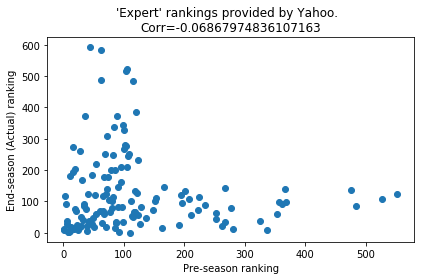

In [17]:
%matplotlib inline
plt.scatter(ranksDF['PreSeasonRank'],ranksDF['EndSeasonRank'])
# Label the axes
plt.xlabel('Pre-season ranking')
plt.ylabel('End-season (Actual) ranking')

#label the figure
plt.title('\'Expert\' rankings provided by Yahoo.  \nCorr={0}'.format(str(rankCorr)))
plt.tight_layout()
plt.savefig(dataFolder + 'expertranks.png')
plt.show()

As we can see, the plot doesn't reflect this at all, so the rest of the analysis will try to make an improvement.  It is interesting to note that on the draft page from the Yahoo web site, the average draft position corresponds very closely to the Preseason rank.  This means that a large majority of fantasy participants use this 'expert' ranking in their draft.  As we can see this may not be the best advice.  If we can find a better predictor, then one should be able to obtain a draft advantage.

In [54]:
# Let's first look at just 2017, last year's stats to see how well they correspond to the Yahoo pre-season ranking for the 2018 season
# For this, create a whole new dataframe using copy
statsDF2017 = statsDF[statsDF['Season'] == 2017].copy()
statsDF2017.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            878, 879, 880, 881, 882, 883, 884, 885, 886, 887],
           dtype='int64', length=888)

In [55]:
def calcCatZ(df, dfcol):
    colMean = df[dfcol].mean()
    colStd = df[dfcol].std()
    return (colMean, colStd)

for curCol in ['G', 'A', 'PM', 'PIM', 'PPP', 'GWG', 'SOG', 'HIT', 'BLK']:
    curMean, curStd = calcCatZ(statsDF2017, curCol)
    statsDF2017[curCol + 'Z'] = (statsDF2017[curCol] - curMean) / curStd

statsDF2017['TotZ'] = statsDF2017['GZ'] + statsDF2017['AZ'] + statsDF2017['PMZ'] + \
                      statsDF2017['PIMZ'] + statsDF2017['PPPZ'] + statsDF2017['SHPZ'] + statsDF2017['GWGZ'] + \
                      statsDF2017['GWGZ'] + statsDF2017['SOGZ'] + statsDF2017['HITZ']
statsDF2017.sort_values('TotZ', ascending=False)

,PlayerName,Team,Pos,GP,G,A,PM,PIM,PPG,PPA,...,AZ,PMZ,PIMZ,PPPZ,SHPZ,GWGZ,SOGZ,HITZ,BLKZ,TotZ
5,Brad Marchand,BOS,LW,80,39,46,18,81,9,15,...,2.613061,1.863847,2.351176,2.753529,5.167555,3.739059,2.028985,-0.167788,-0.105332,27.741969
0,Connor McDavid,EDM,C,82,30,70,27,26,3,24,...,4.493893,2.775466,0.052064,3.179386,1.788476,2.627295,2.385466,-0.477398,-0.249231,22.059931
20,Alex Ovechkin,WSH,LW,82,33,36,6,50,17,9,...,1.829381,0.648354,1.055313,3.037434,-0.464243,3.183177,3.269538,2.837256,-0.249231,21.535875
32,Cam Atkinson,CBJ,RW,82,35,27,13,22,10,11,...,1.124069,1.357391,-0.115144,2.327671,2.914836,4.294941,2.228614,-0.495611,-0.129315,21.120530
35,Viktor Arvidsson,NSH,LW,80,31,30,16,28,4,5,...,1.359173,1.661264,0.135668,0.624240,7.420274,2.627295,2.314170,-0.677735,0.134500,20.815799
8,Brent Burns,SJS,D,82,29,47,19,40,8,17,...,2.691429,1.965138,0.637293,2.895481,0.662117,2.627295,3.369353,0.160035,2.460868,20.127256
26,Jeff Carter,LAK,C,82,32,34,2,41,10,12,...,1.672645,0.243190,0.679095,2.469623,0.662117,4.294941,2.371207,0.469646,-0.057365,19.997726
4,Nikita Kucherov,TBL,RW,74,40,45,13,38,17,15,...,2.534693,1.357391,0.553689,3.889149,-0.464243,3.183177,2.314170,-0.550248,-0.465079,19.770607
23,Joe Pavelski,SJS,C,81,29,39,11,34,7,15,...,2.064485,1.154809,0.386480,2.469623,0.662117,3.183177,2.128800,1.270991,0.806029,18.995481
25,Max Pacioretty,MTL,LW,81,35,32,15,38,8,5,...,1.515909,1.559973,0.553689,1.192050,1.788476,3.183177,2.627873,0.050761,-0.105332,18.843905


In [22]:
# Now creating a ranking column corresponding to each statistical column
statsDF2017['GRnk'] = statsDF2017['G'].rank(ascending=False)
statsDF2017['ARnk'] = statsDF2017['A'].rank(ascending=False)
statsDF2017['PMRnk'] = statsDF2017['PM'].rank(ascending=False)
statsDF2017['PIMRnk'] = statsDF2017['PIM'].rank(ascending=False)
statsDF2017['PPPRnk'] = statsDF2017['PPP'].rank(ascending=False)
statsDF2017['GWGRnk'] = statsDF2017['GWG'].rank(ascending=False)
statsDF2017['SOGRnk'] = statsDF2017['SOG'].rank(ascending=False)
statsDF2017['HITRnk'] = statsDF2017['HIT'].rank(ascending=False)
statsDF2017['BLKRnk'] = statsDF2017['BLK'].rank(ascending=False)
statsDF2017['AvgRnk'] = (statsDF2017['GRnk'] + statsDF2017['ARnk'] + statsDF2017['PMRnk'] + \
                         statsDF2017['PIMRnk'] + statsDF2017['PPPRnk'] + statsDF2017['GWGRnk'] + \
                         statsDF2017['SOGRnk'] + statsDF2017['HITRnk'] + statsDF2017['BLKRnk']) / 9.0
statsDF2017.sort_values('AvgRnk')

,PlayerName,Team,Pos,GP,G,A,PM,PIM,PPP,GWG,...,GRnk,ARnk,PMRnk,PIMRnk,PPPRnk,GWGRnk,SOGRnk,HITRnk,BLKRnk,AvgRnk
8,Brent Burns,SJS,D,82,29,47,19,40,25,6,...,28.5,12.5,33.5,167.0,19.5,27.5,1.0,311.5,36.0,70.777778
23,Joe Pavelski,SJS,C,81,29,39,11,34,22,7,...,28.5,38.0,98.5,236.5,35.5,14.0,28.5,101.0,155.0,81.722222
20,Alex Ovechkin,WSH,LW,82,33,36,6,50,26,7,...,14.5,56.5,183.5,115.0,14.0,14.0,2.0,20.0,412.0,92.388889
148,Shea Weber,MTL,D,78,17,25,20,38,22,4,...,133.0,161.5,30.0,189.0,35.5,86.5,91.0,87.5,21.0,92.777778
48,Ryan Kesler,ANA,C,82,22,36,8,83,20,2,...,74.0,56.5,144.5,29.5,46.5,222.5,83.5,71.5,151.5,97.777778
11,Blake Wheeler,WPG,RW,82,26,48,6,47,21,4,...,43.5,9.5,183.5,132.5,40.5,86.5,13.0,170.5,231.5,101.222222
5,Brad Marchand,BOS,LW,80,39,46,18,81,24,8,...,4.5,16.0,38.0,32.0,24.5,7.0,33.0,420.0,338.0,101.444444
87,Dustin Byfuglien,WPG,D,80,13,39,10,117,14,1,...,200.5,38.0,113.0,7.0,116.5,360.0,22.0,31.0,57.5,105.055556
15,Victor Hedman,TBL,D,79,16,56,3,47,33,5,...,149.5,4.0,248.0,132.5,2.0,51.5,133.5,195.5,49.5,107.333333
136,Patric Hornqvist,PIT,RW,70,21,23,16,28,17,6,...,81.5,179.0,53.0,316.5,74.5,27.5,38.0,14.5,189.0,108.166667
